# Big Data driven automated data analysis and decision-making, the basics of machine learning 

Welcome! 

This is an interactive notebook that demonstrates my work in detail with regards to the ÚNKP scholarship program. Also available on GitHub. 

## Setting up the environment

In [7]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import DateFormatter

import numpy as np
from scipy.stats import pearsonr

from cassandra.cluster import Cluster
from cassandra.metadata import KeyspaceMetadata

## Connect to Cassandra cluster

In [2]:
cluster = Cluster(["172.20.16.137"], port=30241)
keyspace_name = "sensorhub"
session = cluster.connect(keyspace_name)

## Create sample pandas DataFrame
The DataFrame is created by executing a CQL query. This gives us a month worth of data from the SensorHUB framework.

In [3]:
query = "SELECT sensor, datum, temperatureat2meter FROM erti_new WHERE datum >= '2017-01-01 00:00:00' AND  datum <= '2017-01-31 23:59:00' AND sensor=1"
df = pd.DataFrame(list(session.execute(query)))

## Check result

In [4]:
print(df.head())

   sensor               datum  temperatureat2meter
0       1 2017-01-01 00:00:01                 -7.2
1       1 2017-01-01 00:10:01                 -7.2
2       1 2017-01-01 00:20:01                 -7.1
3       1 2017-01-01 00:40:11                 -8.4
4       1 2017-01-01 00:50:01                 -7.9


## Getting the average of the dataset

In [5]:
tempat2mAvg = df['temperatureat2meter'].mean()
print(tempat2mAvg)

-6.794749155185859


## How does our DataFrame look like?

<Figure size 432x288 with 0 Axes>

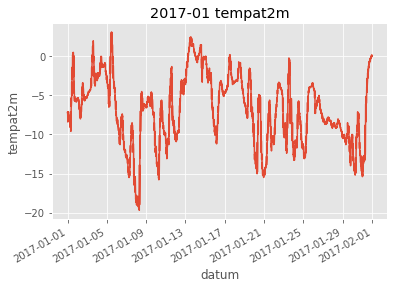

In [6]:
style.use('ggplot')

my_dates = df['datum']

plt.figure()
fig, ax = plt.subplots()

ax.plot(my_dates, df['temperatureat2meter'])

fig.autofmt_xdate()
ax.set_title('2017-01 tempat2m')

plt.xlabel('datum')
plt.ylabel('tempat2m')

plt.grid(True)
plt.show()

## With moving average (per 500 data)
We have to insert another column into our dataset, which will hold the moving averages calculated after every 500 records. 

Text(0.5, 1.0, 'tempat2m with moving avg')

<Figure size 432x288 with 0 Axes>

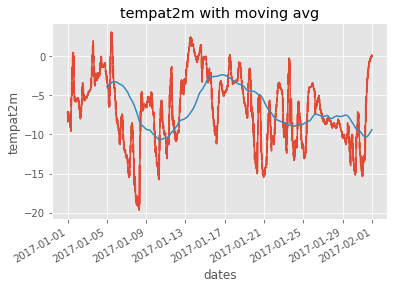

In [7]:
df['MA_500'] = df['temperatureat2meter'].rolling(500).mean()

plt.figure()
fig, ax = plt.subplots()

plt.plot(my_dates, df['temperatureat2meter'], label="tempat2m")
plt.plot(my_dates, df['MA_500'], label="MA_500")

plt.xlabel('dates')
plt.ylabel('tempat2m')

myFmt = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.set_title('tempat2m with moving avg')

## Above average temperatures

<Figure size 432x288 with 0 Axes>

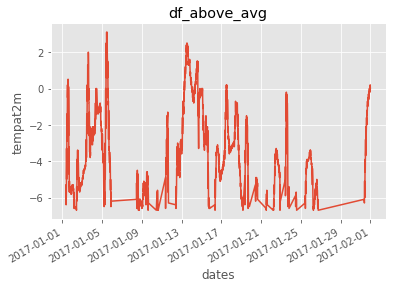

In [8]:
df_above_avg = df.loc[df['temperatureat2meter'] > tempat2mAvg, :]

plt.figure()
fig, ax = plt.subplots()

dates = df_above_avg['datum'].tolist()

ax.plot(dates, df_above_avg['temperatureat2meter'])

plt.xlabel('dates')
plt.ylabel('tempat2m')

myFmt = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title('df_above_avg')
fig.autofmt_xdate()

## Splitting up the dataset into weeks

In [9]:
df['date'] = df['datum'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week

print(df.head())

   sensor               datum  temperatureat2meter  MA_500       date  week
0       1 2017-01-01 00:00:01                 -7.2     NaN 2017-01-01    52
1       1 2017-01-01 00:10:01                 -7.2     NaN 2017-01-01    52
2       1 2017-01-01 00:20:01                 -7.1     NaN 2017-01-01    52
3       1 2017-01-01 00:40:11                 -8.4     NaN 2017-01-01    52
4       1 2017-01-01 00:50:01                 -7.9     NaN 2017-01-01    52


## Average tempat2m by week

In [10]:
weekly_avg = df.groupby('week')['temperatureat2meter'].mean()
print(weekly_avg)

week
1    -6.779839
2    -5.035640
3    -6.530840
4    -8.407135
5    -8.961446
52   -5.408800
Name: temperatureat2meter, dtype: float64


## Making sense of the dataset - separating datetime

In [11]:
df['time'] = df['datum'].dt.time

print(df.head())

   sensor               datum  temperatureat2meter  MA_500       date  week  \
0       1 2017-01-01 00:00:01                 -7.2     NaN 2017-01-01    52   
1       1 2017-01-01 00:10:01                 -7.2     NaN 2017-01-01    52   
2       1 2017-01-01 00:20:01                 -7.1     NaN 2017-01-01    52   
3       1 2017-01-01 00:40:11                 -8.4     NaN 2017-01-01    52   
4       1 2017-01-01 00:50:01                 -7.9     NaN 2017-01-01    52   

       time  
0  00:00:01  
1  00:10:01  
2  00:20:01  
3  00:40:11  
4  00:50:01  


## Getting data from more sensors

Include all sensors.

In [3]:
query2 = "SELECT sensor, datum, temperatureat2meter FROM erti_new WHERE datum >= '2017-01-01 00:00:00' AND  datum <= '2017-01-31 23:59:59' ALLOW FILTERING"
df2 = pd.DataFrame(list(session.execute(query2)))

In [4]:
df2.head()

,sensor,datum,temperatureat2meter
0,5,2017-01-01 00:00:03,-1.7
1,5,2017-01-01 00:10:03,-1.6
2,5,2017-01-01 00:20:03,-1.8
3,5,2017-01-01 00:40:13,-1.9
4,5,2017-01-01 00:50:03,-1.7


## Cleaning up the DataFrame

In [5]:
df2['temperatureat2meter'] = df2['temperatureat2meter'].replace(to_replace=[-888.8, -777.7, -999.9], value=np.NaN)

In [6]:
df2.isnull().values.any()

True

## Plotting average tempat2m from each sensor

In [7]:
grouped = df2['temperatureat2meter'].groupby(df2['sensor'])

In [8]:
mean_of_grouped = grouped.mean()
print(mean_of_grouped)

sensor
1   -6.794749
2   -4.683816
3   -5.370310
4   -6.124344
5   -2.174382
6   -6.450526
Name: temperatureat2meter, dtype: float64


It might occur to us that the 5th sensor has measured a significantly lower average temperature... Why is that? (we won't explore the reasons, for now)

In [9]:
# it seems these frames have to be converted to lists
# in order to be displayed as barcharts
x = list(mean_of_grouped.index)
y = list(mean_of_grouped.values)

print(x)
print(y)

[1, 2, 3, 4, 5, 6]
[-6.794749155185856, -4.683816363170051, -5.37030999465525, -6.124343832020991, -2.1743822491174964, -6.450526315789458]


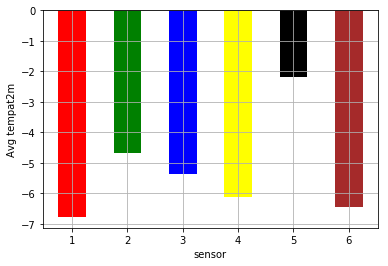

In [10]:
plt.figure()

# random_color = np.random.choice(range(256), size=3)
colors = ['red', 'green', 'blue', 'yellow', 'black', 'brown']

plt.bar(x, y, width=.5, color=colors)

plt.xlabel('sensor')
plt.ylabel('Avg tempat2m')

plt.grid(True)
plt.show()

Let's explore why the 5th sensor has measured a signinficantly lower average tempat2m.

In [12]:
df2[df2.sensor == 2].temperatureat2meter.value_counts()

-5.9     95
-7.4     91
-6.0     71
-5.8     64
-5.4     63
-4.0     61
-7.2     60
-3.9     59
-4.3     55
-7.1     54
-5.7     54
-4.4     51
-4.6     48
-6.1     48
-2.8     48
-6.7     45
-3.3     44
-5.3     44
-6.2     43
-7.6     42
-6.8     42
-6.5     42
-5.5     41
-7.3     41
-2.9     41
-3.2     40
-5.6     40
-3.1     39
-5.0     39
-3.4     37
         ..
-14.5     2
-17.0     2
-14.3     2
-13.1     2
 4.0      2
-16.9     2
 4.8      2
-15.6     2
 3.7      2
-13.3     2
 4.1      1
-13.8     1
-15.9     1
-14.4     1
-17.9     1
-13.7     1
-14.8     1
-15.1     1
-17.7     1
-12.5     1
-15.3     1
-16.5     1
-15.7     1
-18.6     1
 3.0      1
-15.5     1
-18.0     1
-16.0     1
-13.5     1
-12.9     1
Name: temperatureat2meter, Length: 217, dtype: int64

## Calculating Cohen's effect size for two groups

In [21]:
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [22]:
# creating two groups
sensor5_temp = df2[df2.sensor == 5].temperatureat2meter
sensor2_temp = df2[df2.sensor == 2].temperatureat2meter

In [24]:
CohenEffectSize(sensor5_temp, sensor2_temp)

0.7396660964541354

In [16]:
print('Len of sensor6_temp', len(sensor6_temp))
print('Len of sensor2_temp', len(sensor2_temp))

Len of sensor6_temp 3895
Len of sensor2_temp 3899


In [17]:
sensor6_temp.isnull().sum()

0

In [18]:
sensor2_temp.isnull().sum()

0

<Figure size 432x288 with 0 Axes>

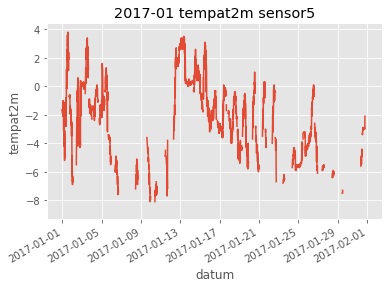

In [20]:
style.use('ggplot')

my_dates = df2[df2.sensor == 5].datum

plt.figure()
fig, ax = plt.subplots()

ax.plot(my_dates, df2[df2.sensor == 5].temperatureat2meter)

fig.autofmt_xdate()
ax.set_title('2017-01 tempat2m sensor5')

plt.xlabel('datum')
plt.ylabel('tempat2m')

plt.grid(True)
plt.show()

It has become obvious why the drastic difference between the calculated averages... The 5th sensor hasn't sent any data for most of January!

## New dataset

In [11]:
query3 = "SELECT sensor, datum, temperatureat2meter, windspeed, relativehumidity FROM erti_new WHERE datum >= '2017-01-01 00:00:00' AND  datum <= '2017-01-31 23:59:59' ALLOW FILTERING"
df3 = pd.DataFrame(list(session.execute(query3)))

## Pearson correlation 

Calculating the Pearson correlation between two attributes: tempat2m, and windspeed.

In [12]:
df3['windspeed'].head()

0    1.1
1    0.9
2    0.9
3    0.8
4    0.9
Name: windspeed, dtype: float64

In [13]:
pearsonr(df3['windspeed'], df3['temperatureat2meter'])

(0.9998943946698517, 0.0)

Calculating the Pearson correlation between two attributes: tempat2m, and relativehumidity.

In [14]:
df3['relativehumidity'].head()

0    73.6
1    72.6
2    73.3
3    72.2
4    70.8
Name: relativehumidity, dtype: float64

In [15]:
pearsonr(df3['relativehumidity'], df3['temperatureat2meter'])

(0.9993104307407322, 0.0)